In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch

from rfest import LNLN, splineLNLN
from rfest.MF import KMeans, semiNMF

from rfest.metrics import mse
from rfest.utils import uvec, get_n_samples, build_design_matrix
from rfest.simulate import mexicanhat2d, gaussian2d, noise2d, get_subunits_response

In [2]:
def reorder(T, E):
    
    def distance(a, b):
        return np.mean((a - b)**2)
  
    Tdict = {i:t for i, t in enumerate(T.T)}
    Edict = {i:t for i, t in enumerate(E.T)}
  
    res_idx = []
    res_dis = []
    for ti, t in Tdict.items():
        res_row = {}
        Edict_temp = Edict.copy()
        for ei, e in Edict_temp.items():
    #         print(ti, ei, distance(t.flatten(), e.flatten()))
            res_row[ei] = distance(uvec(t.flatten()), uvec(e.flatten()))
        res_row_min = min(res_row, key=res_row.get)
        res_idx.append(res_row_min)
        res_dis.append(res_row[res_row_min])
        del Edict[res_row_min]
        Edict_temp = Edict.copy()
        
    res_idx = np.array(res_idx)
    print(res_idx, np.mean(res_dis))
    return E[:, res_idx], np.mean(res_dis)

def get_vmax(w):
    vmax = np.max([np.abs(w.max()), np.abs(w.min())])
    return vmax

In [3]:
dims = [20, 20]
n_features = np.prod(dims)

# k0 = gaussian2d(dims, [3, 3])
k0 = mexicanhat2d(dims, [3, 3])

k1 = np.vstack([np.roll(k0[i, :], 1) for i in range(dims[0])])
k2 = -np.vstack([np.roll(k0[i, :], -1) for i in range(dims[0])])
w_true = np.vstack([k2.flatten(), k1.flatten()]).T

dt = 0.033
recording_length = np.array([0.5, 1, 2, 4, 8, 16, 32, 64])
rnd_seed_list = np.arange(10)
n_samples_list = get_n_samples(recording_length, dt)

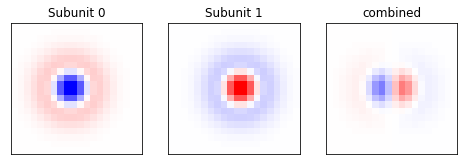

In [4]:
fig, ax = plt.subplots(1,3, figsize=(8,4))
for i in range(3):
    if i < 2:
    
        ax[i].imshow(w_true[:, i].reshape(dims), cmap=plt.cm.bwr, vmin=-0.3, vmax=0.3)
        ax[i].set_title(f'Subunit {i}')
    else:
        ax[i].imshow(w_true.mean(1).reshape(dims), cmap=plt.cm.bwr, vmin=-0.3, vmax=0.3)
        ax[i].set_title('combined')
    ax[i].set_xticks([])
    ax[i].set_yticks([])


In [5]:
dt = 0.033
R = 5
intercept = 0.
# rnd_seed = 0
# X_wn = noise2d(n_samples=n_samples_list[-1], dims=dims, beta=0, random_seed=0).reshape(n_samples_list[-1], n_features)
# y_wn = get_subunits_response(X_wn, w_true, dt=dt, R=R, intercept=intercept, 
#                     distr='poisson', nl0='exponential', nl1='softplus',
#                     random_seed=rnd_seed)

In [6]:
# lnln = splineLNLN(X_wn, y_wn, dims=dims, df=[9,9], filter_nonlinearity='exponential')
# lnln.fit(num_subunits=2, num_iters=3000, verbose=300, beta=5.)

In [7]:
# w_opt, _ = reorder(w_true, lnln.w_opt)
# fig, ax = plt.subplots(1,3, figsize=(8,4))
# for i in range(3):
#     if i < 2:
#         ax[i].imshow(w_opt[:, i].reshape(dims), cmap=plt.cm.bwr, vmin=-0.3, vmax=0.3)
#         ax[i].set_title(f'Subunit {i}')
#     else:
#         ax[i].imshow(w_opt.mean(1).reshape(dims), cmap=plt.cm.bwr, vmin=-0.3, vmax=0.3)
#         ax[i].set_title('combined')
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])

In [ ]:
dis_all = []
dis_norm_all = []
res_ws_all = []
niters = 3000

for ii, random_seed in enumerate(rnd_seed_list):

    res_lnln_with_spline = []
    res_kms_with_spline = []
    res_nmf_with_spline = []
    res_lnln_without_spline = []
    res_kms_without_spline = []
    res_nmf_without_spline = []
    
    X_wn = noise2d(n_samples=n_samples_list[-1], dims=dims, beta=0, random_seed=random_seed).reshape(n_samples_list[-1], n_features)
    y_wn = get_subunits_response(X_wn, w_true, dt=dt, R=R, intercept=intercept, 
                        distr='poisson', nl0='exponential', nl1='softplus',
                        random_seed=random_seed) 
    
    print(f'rnd_seed={random_seed}')
    for jj, n_samples in enumerate(n_samples_list):
        
        
        Xe = X_wn[:n_samples][y_wn[:n_samples]!=0]
        
        print(f'Calculating n_effective={np.sum([y_wn[:n_samples]!=0])} | n_samples={n_samples} | time={recording_length[jj]}')
        
        lnln_2d_with_spline = splineLNLN(X_wn[:n_samples], y_wn[:n_samples], dims=dims, df=[9,9], dt=dt, compute_mle=False, 
                          filter_nonlinearity='exponential', output_nonlinearity='softplus')
        lnln_2d_with_spline.fit(num_subunits=2, num_iters=niters, alpha=1, 
                                beta=1., verbose=0, tolerance=100,
                   random_seed=random_seed)

        kms_2d_with_splines = KMeans(Xe.T, k=2, build_S=True, dims=dims, df=[9,9], random_seed=random_seed)
        kms_2d_with_splines.fit(num_iters=niters, verbose=0)

        nmf_2d_with_splines = semiNMF(Xe.T, k=2, build_S=True, dims=dims, df=[9,9], random_seed=random_seed)
        nmf_2d_with_splines.fit(num_iters=niters, verbose=0)
        
        switch = True
        beta_ = 1
        while switch:
            lnln_2d_without_spline = LNLN(X_wn[:n_samples], y_wn[:n_samples], dims=dims, dt=dt, compute_mle=False, 
                      filter_nonlinearity='exponential', output_nonlinearity='softplus')
            try:
                print(f'beta_ = {beta_}')
                lnln_2d_without_spline.fit(num_subunits=2, num_iters=niters, alpha=1, 
                                   beta=beta_, verbose=0, tolerance=100,
                   random_seed=random_seed)
                switch = False
            except:
                beta_ += 1.

        kms_2d_without_splines = KMeans(Xe.T, k=2, build_S=False, random_seed=random_seed)
        kms_2d_without_splines.fit(num_iters=niters, verbose=0)

        nmf_2d_without_splines = semiNMF(Xe.T, k=2, build_S=False, random_seed=random_seed)
        nmf_2d_without_splines.fit(num_iters=niters, verbose=0)
        
        
        res_lnln_with_spline.append(lnln_2d_with_spline.w_opt)
        res_kms_with_spline.append(kms_2d_with_splines.W)
        res_nmf_with_spline.append(nmf_2d_with_splines.W)
        
        res_lnln_without_spline.append(lnln_2d_without_spline.w_opt)
        res_kms_without_spline.append(kms_2d_without_splines.W)
        res_nmf_without_spline.append(nmf_2d_without_splines.W)
        
    
    res_ws = [res_lnln_with_spline, res_kms_with_spline, res_nmf_with_spline, 
              res_lnln_without_spline, res_kms_without_spline, res_nmf_without_spline]
    res_ws_all.append(res_ws)

rnd_seed=0
Calculating n_effective=235 | n_samples=909 | time=0.5


In [ ]:
ws_all = []
dis_all = []
for i in range(len(rnd_seed_list)):
    ws_one = []
    dis_one = []
    for j in range(6):
        ws = []
        dis = []
        for k in range(8):
            w_new, dis_new = reorder(w_true, res_ws_all[i][j][k])
            ws.append(w_new)
            dis.append(dis_new)
        ws_one.append(ws)
        dis_one.append(dis)
    ws_all.append(ws_one)
    dis_all.append(dis_one)
dis_all_arr = np.array(dis_all)

In [ ]:
w_opt, _ = reorder(w_true, res_lnln_without_spline[-1])
fig, ax = plt.subplots(1,3, figsize=(8,4))
for i in range(3):
    if i < 2:
        ax[i].imshow(w_opt[:, i].reshape(dims), cmap=plt.cm.bwr, vmin=-0.3, vmax=0.3)
        ax[i].set_title(f'Subunit {i}')
    else:
        ax[i].imshow(w_opt.mean(1).reshape(dims), cmap=plt.cm.bwr, vmin=-0.3, vmax=0.3)
        ax[i].set_title('combined')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [ ]:
w_opt, _ = reorder(w_true, lnln_2d_with_spline.w_opt)
fig, ax = plt.subplots(1,3, figsize=(8,4))
for i in range(3):
    if i < 2:
        ax[i].imshow(w_opt[:, i].reshape(dims), cmap=plt.cm.bwr, vmin=-0.3, vmax=0.3)
        ax[i].set_title(f'Subunit {i}')
    else:
        ax[i].imshow(w_opt.mean(1).reshape(dims), cmap=plt.cm.bwr, vmin=-0.3, vmax=0.3)
        ax[i].set_title('combined')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [ ]:
def panel_specs(layout, fig=None):
    # default arguments
    if fig is None:
        fig = plt.gcf()
    # format and sanity check grid
    lines = layout.split('\n')
    lines = [line.strip() for line in lines if line.strip()]
    linewidths = set(len(line) for line in lines)
    if len(linewidths)>1:
        raise ValueError('Invalid layout (all lines must have same width)')
    width = linewidths.pop()
    height = len(lines)
    panel_letters = set(c for line in lines for c in line)-set('.')
    # find bounding boxes for each panel
    panel_grid = {}
    for letter in panel_letters:
        left = min(x for x in range(width) for y in range(height) if lines[y][x]==letter)
        right = 1+max(x for x in range(width) for y in range(height) if lines[y][x]==letter)
        top = min(y for x in range(width) for y in range(height) if lines[y][x]==letter)
        bottom = 1+max(y for x in range(width) for y in range(height) if lines[y][x]==letter)
        panel_grid[letter] = (left, right, top, bottom)
        # check that this layout is consistent, i.e. all squares are filled
        valid = all(lines[y][x]==letter for x in range(left, right) for y in range(top, bottom))
        if not valid:
            raise ValueError('Invalid layout (not all square)')
    # build axis specs
    gs = gridspec.GridSpec(ncols=width, nrows=height, figure=fig)
    specs = {}
    for letter, (left, right, top, bottom) in panel_grid.items():
        specs[letter] = gs[top:bottom, left:right]
    return specs, gs

def panels(layout, fig=None):
    axes = {}
    # default arguments
    if fig is None:
        fig = plt.gcf()
    specs, gs = panel_specs(layout, fig=fig)
    for letter, spec in specs.items():
        axes[letter] = fig.add_subplot(spec)
    return axes, gs

def label_panel(ax, letter, *, prefix='', postfix='.', spaces=6, pad=10, fontsize=18):
    ax.set_title(prefix+letter+postfix+' '*spaces, loc='left', pad=pad,
                 fontdict={'horizontalalignment': 'right',
                           'fontsize': fontsize})

def label_panels(axes, letters=None, *, prefix='', postfix='.', spaces=6, pad=10, fontsize=18):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, prefix=prefix, postfix=postfix, spaces=spaces, pad=pad, fontsize=fontsize)
    
def set_title(axes, letters, title, title_pos=0.88, border_pos=1, border_width=1,
              fontsize=14):
    """
    source: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
    """
    
    ext = []
    for letter in letters:
        ext.append([axes[letter].get_window_extent().x0, axes[letter].get_window_extent().width ])
    
    num_letters = len(letters)-1
    
    inv = fig.transFigure.inverted()
    width = ext[0][0]+(ext[num_letters][0]+ext[num_letters][1]-ext[0][0])/2.
    center = inv.transform( (width, 1) )
    
    plt.figtext(center[0], title_pos, title, va="center", ha="center", size=fontsize)
    
    cp = ConnectionPatch((0, border_pos), (1, border_pos), "axes fraction", "axes fraction",
                          axesA=axes[letters[0]], axesB=axes[letters[1]], linewidth=border_width)

    axes[letters[0]].add_artist(cp)

In [ ]:
# # layout = '''
# #     cc.ddee.ffgg
# #     AB.CDEF.GHIJ
# #     ...KLMN.OPQR
# #     ...STUV.WXYZ
# #     ...xxxx.yyyy
# #     ...xxxx.yyyy
# #  '''
# # layout = '''
# #     cccc.ddddeeee.ffffgggg
# #     AABB.CCDDEEFF.GGHHIIJJ
# #     AABB.CCDDEEFF.GGHHIIJJ
# #     .....KKLLMMNN.OOPPQQRR
# #     .....KKLLMMNN.OOPPQQRR
# #     .....SSTTUUVV.WWXXYYZZ
# #     .....SSTTUUVV.WWXXYYZZ
# #     .....xxxxxxxx.yyyyyyyy
# #     .....xxxxxxxx.yyyyyyyy
# # '''
# layout = '''
#     AB.CDEF.GHIJ
#     ...KLMN.OPQR
#     ...STUV.WXYZ
#     ...xxxx.yyyy
#     ...xxxx.yyyy
#  ''' 

# alphas = [0.2, 0.6, 1]

# fig = plt.figure(figsize=(12, 9))
# axes, spec = panels(layout, fig=fig)
# # spec.set_height_ratios([0.1, 1., 1., 1., 1., 1.])
# # spec.set_height_ratios([1., 1., 1., 1.])

# letters_pairs = ['AB', 'CD', 'EF', 'GH', 'IJ',
#                        'KL', 'MN', 'OP', 'QR',
#                        'ST', 'UV', 'WX', 'YZ']

# rnd_idx = 0
# ws = [w_true, 
#       ws_all[rnd_idx][4][3], ws_all[rnd_idx][4][6], ws_all[rnd_idx][1][3], ws_all[rnd_idx][1][6], 
#       ws_all[rnd_idx][5][3], ws_all[rnd_idx][5][6], ws_all[rnd_idx][2][3], ws_all[rnd_idx][2][6], 
#       ws_all[rnd_idx][3][3], ws_all[rnd_idx][3][6], ws_all[rnd_idx][0][3], ws_all[rnd_idx][0][6],
# ]

# for idx, w in enumerate(ws):
#     for idy, letter in enumerate(letters_pairs[idx]):
#         k = w[:, idy]
#         vmax = get_vmax(k)    
#         axes[letter].imshow(k.reshape(dims), plt.cm.bwr, vmin=-vmax, vmax=vmax)



# for letter in range(ord('A'), ord('Z')+1):
#     letter = chr(letter)
#     axes[letter].set_xticks([])
#     axes[letter].set_yticks([])
    
# ylabels = ['k-means', 'NMF', 'LNLN']
# for idx, letter in enumerate('CKS'):
#     axes[letter].set_ylabel(ylabels[idx], fontsize=12)
    

# # for letter in range(ord('c'), ord('g')+1):
# #     letter = chr(letter)
# #     axes[letter].axis('off')

# short = 4
# long = 32

# # axes['c'].text(0.5, 0.5, 'Ground Truth', fontsize=14, horizontalalignment='center', verticalalignment='center')

# # axes['d'].axhline(0.2, color='black', lw=1)
# # axes['e'].axhline(0.2, color='black', lw=1)
# # axes['d'].text(0.5, 0.5, f'{short} mins', fontsize=14, horizontalalignment='center', verticalalignment='center')
# # axes['e'].text(0.5, 0.5, f'{long} mins', fontsize=14,  horizontalalignment='center', verticalalignment='center')

# # axes['f'].axhline(0.2, color='black', lw=1)
# # axes['g'].axhline(0.2, color='black', lw=1)
# # axes['f'].text(0.5, 0.5, f'{short} mins', fontsize=14, horizontalalignment='center', verticalalignment='center')
# # axes['g'].text(0.5, 0.5, f'{long} mins', fontsize=14,  horizontalalignment='center', verticalalignment='center')

# for letter in 'xy':
#     axes[letter].set_xticks(np.arange(8))
#     xticklabel = ['1/2', '1', '2', '4', '8', '16', '32', '64']
#     axes[letter].set_xticklabels(xticklabel, fontsize=12)
#     #     axes[letter].tick_params(axis='both', labelsize=12)    
#     axes[letter].ticklabel_format(axis='y', style='sci', useOffset=True, scilimits=(0,0))

#     axes[letter].spines['right'].set_visible(False)
#     axes[letter].spines['top'].set_visible(False)
#     axes[letter].set_xlabel('Data (minutes)', fontsize=14)

#     axes[letter].axvline(3, color='grey', alpha=0.5, ls='--', zorder=99)
#     axes[letter].axvline(6, color='gray', alpha=1.0, ls='--', zorder=99)
    
#     axes[letter].set_ylim(-0.0002, 0.005)

# axes['x'].set_ylabel('MSE', fontsize=14)


# axes['y'].set_yticklabels([])

# titles = ['LNLN', 'k-Means', 'semi-NMF']


# for i in range(3):
#     x = np.arange(8)

#     y = dis_all_arr[:].mean(0)[i]
#     yerr = dis_all_arr[:].std(0)[i]
#     axes['y'].errorbar(x=x+i*0.09, y=y, yerr=yerr, marker='o', markersize=5, label=titles[i], color=f'C{i}')
#     axes['y'].legend(frameon=False, loc='upper right', bbox_to_anchor=(1.0, 1.0))



# for i in range(3):
#     x = np.arange(8)

#     y = dis_all_arr[:].mean(0)[i+3]
#     yerr = dis_all_arr[:].std(0)[i+3]
#     axes['x'].errorbar(x=x+i*0.09, y=y, yerr=yerr, marker='o', markersize=5, 
#                        color=f'C{i}', linestyle='-')

# set_title(axes, 'AB', 'Ground Truth', title_pos=0.88, border_pos=1.22)
# set_title(axes, 'CD', '4 mins', title_pos=0.88, border_pos=1.22)
# set_title(axes, 'EF', '32 mins', title_pos=0.88, border_pos=1.22)

# set_title(axes, 'GH', '4 mins', title_pos=0.88, border_pos=1.22)
# set_title(axes, 'IJ', '32 mins', title_pos=0.88, border_pos=1.22)

# set_title(axes, 'CF', 'Without Splines', title_pos=0.93, border_pos=1.9, border_width=2)
# set_title(axes, 'GJ', 'With Splines', title_pos=0.93, border_pos=1.9, border_width=2)
# # 
# fig.savefig('PDF/Figure_Subunits_2D_randomseed10.pdf', bbox_inches='tight', pad_inches = 0.1)

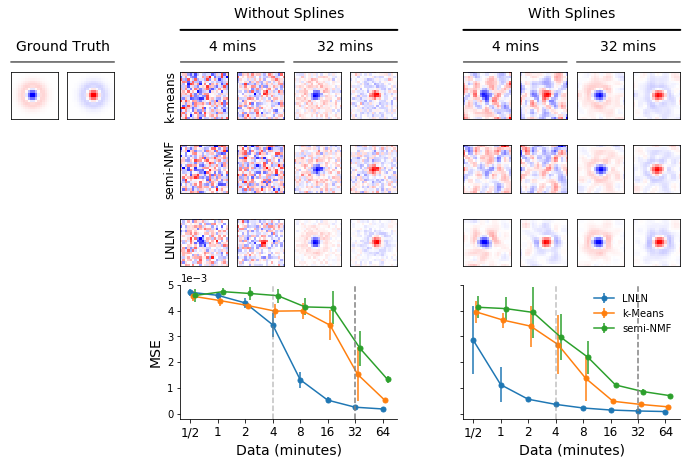

In [15]:
layout = '''
    AB.CDEF.GHIJ
    ...KLMN.OPQR
    ...STUV.WXYZ
    ...xxxx.yyyy
    ...xxxx.yyyy
 ''' 

fig = plt.figure(figsize=(12, 6.5))
axes, spec = panels(layout, fig=fig)
# spec.set_height_ratios([1., .1, .1, .1, 1.])

letters_pairs = ['AB', 'CD', 'EF', 'GH', 'IJ',
                       'KL', 'MN', 'OP', 'QR',
                       'ST', 'UV', 'WX', 'YZ']

rnd_idx = 0
ws = [w_true, 
      ws_all[rnd_idx][4][3], ws_all[rnd_idx][4][6], ws_all[rnd_idx][1][3], ws_all[rnd_idx][1][6], 
      ws_all[rnd_idx][5][3], ws_all[rnd_idx][5][6], ws_all[rnd_idx][2][3], ws_all[rnd_idx][2][6], 
      ws_all[rnd_idx][3][3], ws_all[rnd_idx][3][6], ws_all[rnd_idx][0][3], ws_all[rnd_idx][0][6],
]

for idx, w in enumerate(ws):
    for idy, letter in enumerate(letters_pairs[idx]):
        k = w[:, idy]
        vmax = get_vmax(k)    
        axes[letter].imshow(k.reshape(dims), plt.cm.bwr, vmin=-vmax, vmax=vmax)



for letter in range(ord('A'), ord('Z')+1):
    letter = chr(letter)
    axes[letter].set_xticks([])
    axes[letter].set_yticks([])
    
ylabels = ['k-means', 'semi-NMF', 'LNLN']
for idx, letter in enumerate('CKS'):
    axes[letter].set_ylabel(ylabels[idx], fontsize=12)
    
short = 4
long = 32


for letter in 'xy':
    axes[letter].set_xticks(np.arange(8))
    xticklabel = ['1/2', '1', '2', '4', '8', '16', '32', '64']
    axes[letter].set_xticklabels(xticklabel, fontsize=12)
    #     axes[letter].tick_params(axis='both', labelsize=12)    
    axes[letter].ticklabel_format(axis='y', style='sci', useOffset=True, scilimits=(0,0))

    axes[letter].spines['right'].set_visible(False)
    axes[letter].spines['top'].set_visible(False)
    axes[letter].set_xlabel('Data (minutes)', fontsize=14)

    axes[letter].axvline(3, color='grey', alpha=0.5, ls='--', zorder=99)
    axes[letter].axvline(6, color='gray', alpha=1.0, ls='--', zorder=99)
    
    axes[letter].set_ylim(-0.0002, 0.005)

axes['x'].set_ylabel('MSE', fontsize=14)


axes['y'].set_yticklabels([])

titles = ['LNLN', 'k-Means', 'semi-NMF']


for i in range(3):
    x = np.arange(8)

    y = dis_all_arr[:].mean(0)[i]
    yerr = dis_all_arr[:].std(0)[i]
    axes['y'].errorbar(x=x+i*0.09, y=y, yerr=yerr, marker='o', markersize=5, label=titles[i], color=f'C{i}')
    axes['y'].legend(frameon=False, loc='upper right', bbox_to_anchor=(1.0, 1.0))

for i in range(3):
    x = np.arange(8)

    y = dis_all_arr[:].mean(0)[i+3]
    yerr = dis_all_arr[:].std(0)[i+3]
    axes['x'].errorbar(x=x+i*0.09, y=y, yerr=yerr, marker='o', markersize=5, 
                       color=f'C{i}', linestyle='-')

set_title(axes, 'AB', 'Ground Truth', title_pos=0.92, border_pos=1.22)
set_title(axes, 'CD', '4 mins', title_pos=0.92, border_pos=1.22)
set_title(axes, 'EF', '32 mins', title_pos=0.92, border_pos=1.22)

set_title(axes, 'GH', '4 mins', title_pos=0.92, border_pos=1.22)
set_title(axes, 'IJ', '32 mins', title_pos=0.92, border_pos=1.22)

set_title(axes, 'CF', 'Without Splines', title_pos=.99, border_pos=1.9, border_width=2)
set_title(axes, 'GJ', 'With Splines', title_pos=.99, border_pos=1.9, border_width=2)
fig.savefig('figs/fig4.pdf', bbox_inches='tight', pad_inches = 0.1)